In [265]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor




# Set the display options to print the dataframe
# pd.options.display.float_format = '{:,.3f}'.format

We are going to try and predict air bnb prices in NY based off of information about the airbnb

In [266]:
# Readin the data
air_df = pd.read_csv('Data/AB_NYC_2019.csv')
air_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [267]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

After the quick look at all of our data's features and their types, lets now examine the distribution for our target value, price:

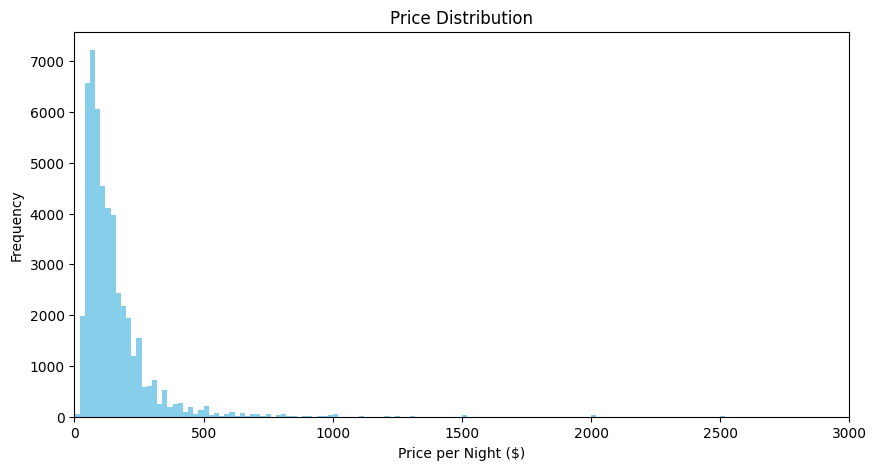

In [268]:
# Plot Histogram of the price distirbution

# Make the figure
fig, ax = plt.subplots(figsize = (10,5))

# set labels
ax.set_xlabel("Price per Night ($)")
ax.set_ylabel("Frequency")
ax.set_title("Price Distribution")

# change x axis to only show values between 0 and 3000
plt.xlim(0, 3000)

plt.hist(air_df['price'], bins = 500, color = 'skyblue')
plt.show()

Find the minimum, maximum, median, and mean price in our data

In [269]:
# we can get most of our required values from the .describe() function in pandas
price_summary = air_df['price'].describe()

# Extracting median separately
median_price = air_df['price'].median()

print("Summary statistics for price:")
print(price_summary)
print("Median price:", median_price)

Summary statistics for price:
count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64
Median price: 106.0


Now lets examine the distribution for other features of the data. lets try to focus on ones that wil help us best predict the value of price. From real world experience, my assumptions for two features that will give us the most insight are neighborhood, minimum_nights, and room_type.

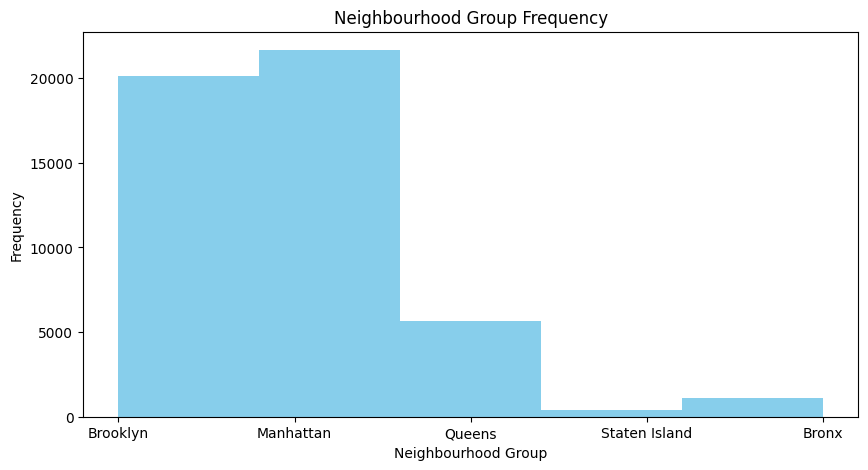

In [270]:
# Plot Histogram of the neighbourhood_group

# Make the figure
fig, ax = plt.subplots(figsize = (10,5))

# set labels
ax.set_xlabel("Neighbourhood Group")
ax.set_ylabel("Frequency")
ax.set_title("Neighbourhood Group Frequency")

# change x axis to only show values between 0 and 3000
#plt.xlim(0, 3000)

plt.hist(air_df['neighbourhood_group'], bins = 5, color = 'skyblue')
plt.show()

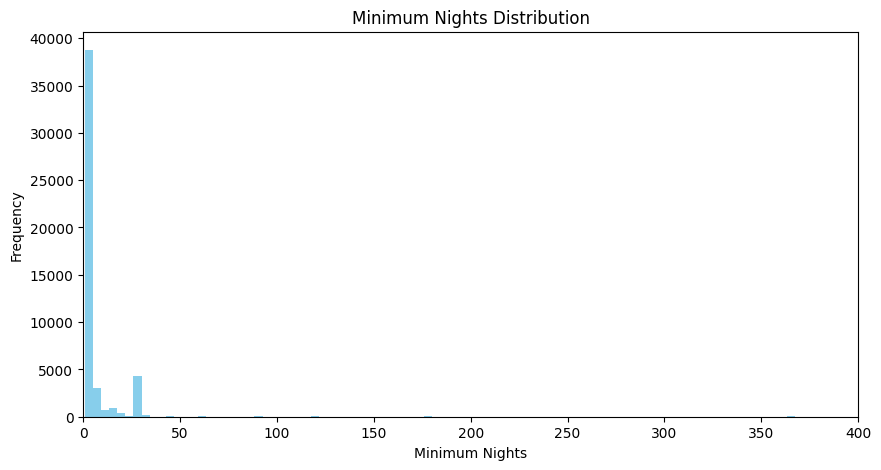

In [271]:
# Plot Histogram of the minimum_nights

# Make the figure
fig, ax = plt.subplots(figsize = (10,5))

# set labels
ax.set_xlabel("Minimum Nights")
ax.set_ylabel("Frequency")
ax.set_title("Minimum Nights Distribution")

# change x axis to only show values between 0 and 3000
plt.xlim(0, 400)

plt.hist(air_df['minimum_nights'], bins = 300, color = 'skyblue')
plt.show()

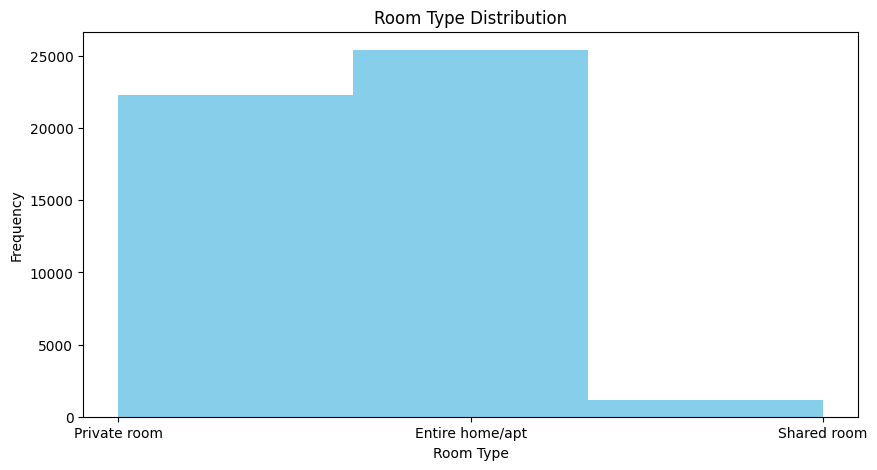

In [272]:
# Plot Histogram of the room_type

# Make the figure
fig, ax = plt.subplots(figsize = (10,5))

# set labels
ax.set_xlabel("Room Type")
ax.set_ylabel("Frequency")
ax.set_title("Room Type Distribution")

# change x axis to only show values between 0 and 3000
#plt.xlim(0, 400)

plt.hist(air_df['room_type'], bins = 3, color = 'skyblue')
plt.show()

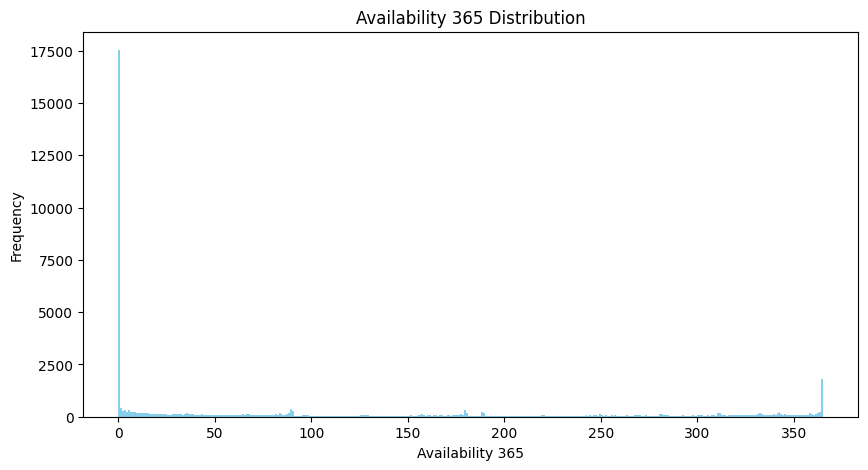

In [273]:
# Plot Histogram of the availability_365

# Make the figure
fig, ax = plt.subplots(figsize = (10,5))

# set labels
ax.set_xlabel("Availability 365")
ax.set_ylabel("Frequency")
ax.set_title("Availability 365 Distribution")

# change x axis to only show values between 0 and 3000
#plt.xlim(0, 400)

plt.hist(air_df['availability_365'], bins = 365, color = 'skyblue')
plt.show()

Now, lets see if we have any null values in our dataset and how many we have

In [274]:
import pandas as pd

# Assuming your DataFrame is named 'airbnb_data'
missing_values = air_df.isnull().sum()

# Calculate the percentage of missing values for each column
total_rows = len(air_df)
missing_percentage = (missing_values / total_rows) * 100

print("Missing values by column:")
print(missing_values)
print("\nPercentage of missing values by column:")
print(missing_percentage)


Missing values by column:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Percentage of missing values by column:
id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude        

Lets calculate the percentage of missing data of our ENTIRE data set

In [275]:
total_entries = air_df.size
missing_values_total = air_df.isnull().sum().sum()

# Calculate the percentage of missing values in the entire dataset
missing_percentage_total = (missing_values_total / total_entries) * 100

print("Total missing values:", missing_values_total)
print("Total entries:", total_entries)
print("Percentage of missing values in the entire dataset:", missing_percentage_total)


Total missing values: 20141
Total entries: 782320
Percentage of missing values in the entire dataset: 2.574521934758155


Now, from our histograms alone we can see that we do have outliers. Lets check which features have outliers based on IQR

In [276]:
# Specify the features you want to check for outliers
features_to_check = ['price','minimum_nights','number_of_reviews']

for feature in features_to_check:
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = air_df[feature].quantile(0.25)
    Q3 = air_df[feature].quantile(0.75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Determine the outlier step (1.5 times the IQR)
    outlier_step = 1.5 * IQR
    
    # Identify outliers
    outliers = air_df[(air_df[feature] < (Q1 - outlier_step)) | (air_df[feature] > (Q3 + outlier_step))]
    
    print("Outliers identified in", feature, ":", outliers)


Outliers identified in price :              id                                               name    host_id  \
61        15396                 Sunny & Spacious Chelsea Apartment      60278   
85        19601                perfect for a family or small group      74303   
103       23686  2000 SF 3br 2bath West Village private  townhouse      93790   
114       26933  2 BR / 2 Bath Duplex Apt with patio! East Village      72062   
121       27659                   3 Story Town House in Park Slope     119588   
...         ...                                                ...        ...   
48758  36420289    Rustic Garden House Apt, 2 stops from Manhattan   73211393   
48833  36450896   Brand New 3-Bed Apt in the Best Location of FiDi   29741813   
48839  36452721  Massage Spa. Stay overnight. Authors Artist dr...  274079964   
48842  36453160  LUXURY MANHATTAN PENTHOUSE+HUDSON RIVER+EMPIRE...  224171371   
48856  36457700  Large 3 bed, 2 bath , garden , bbq , all you need   66993395 

Let's try and visualize some of the outliers using a scatterplot of the prices of all the listings

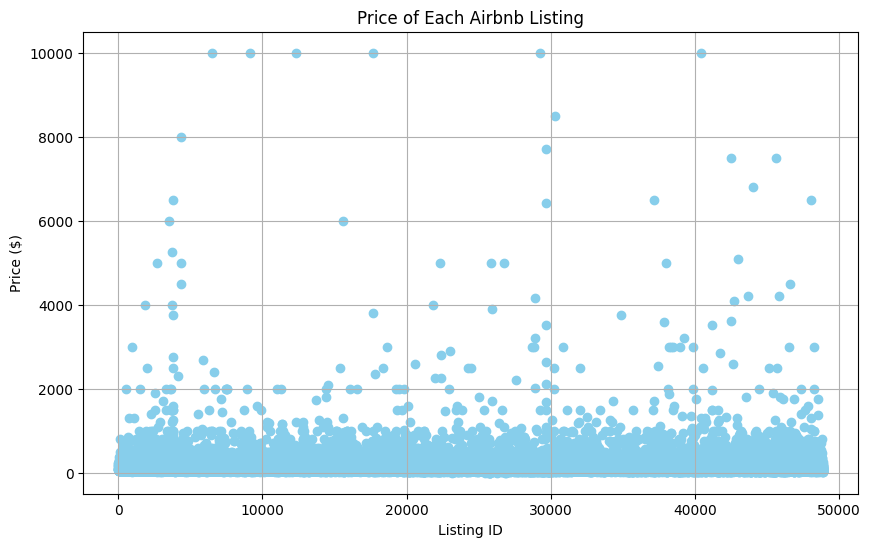

In [277]:
# Plotting the price of each Airbnb listing
plt.figure(figsize=(10, 6))
plt.scatter(range(len(air_df)), air_df['price'], color='skyblue')
plt.title('Price of Each Airbnb Listing')
plt.xlabel('Listing ID')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()


Now, lets look for correlations. We are going to do this by plotting the correlation matrix for all features in our data

In [278]:
columns_except_price = air_df.drop(columns=['price', 'id', 'host_name', 'name']).columns.tolist()
X = pd.get_dummies(columns_except_price, drop_first=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   calculated_host_listings_count  12 non-null     uint8
 1   host_id                         12 non-null     uint8
 2   last_review                     12 non-null     uint8
 3   latitude                        12 non-null     uint8
 4   longitude                       12 non-null     uint8
 5   minimum_nights                  12 non-null     uint8
 6   neighbourhood                   12 non-null     uint8
 7   neighbourhood_group             12 non-null     uint8
 8   number_of_reviews               12 non-null     uint8
 9   reviews_per_month               12 non-null     uint8
 10  room_type                       12 non-null     uint8
dtypes: uint8(11)
memory usage: 264.0 bytes


In [279]:
# Create the target (or outcome) field
y = air_df['price']

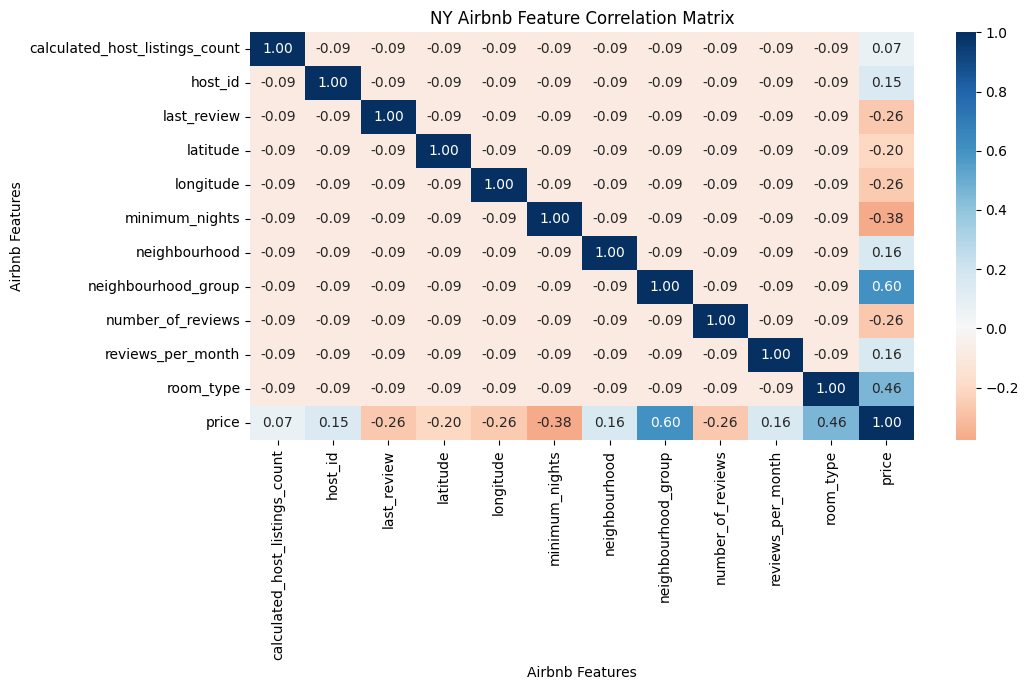

In [280]:
corr = pd.concat([X, y], axis=1).corr()

# Include information about values
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(11, 7)) 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", center=0, ax=ax);
ax.set_title('NY Airbnb Feature Correlation Matrix')
ax.set_xlabel('Airbnb Features')
ax.set_ylabel('Airbnb Features')

plt.tight_layout()
plt.show()


Now, lets examine some of the correlations more closely using histograms, box plots, and scatter plots

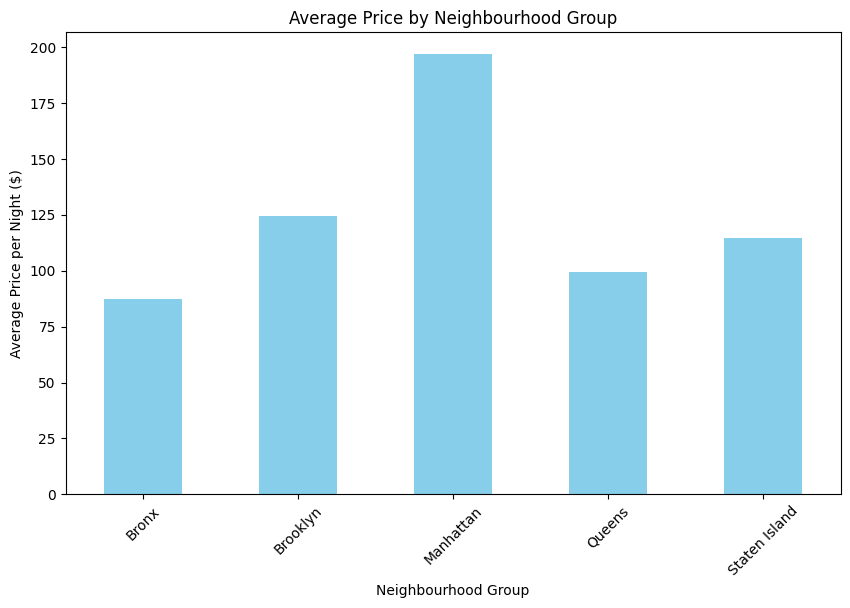

In [281]:
# Group data by 'neighbourhood_group' and calculate mean
average_price_by_neighbourhood_group = air_df.groupby('neighbourhood_group')['price'].mean()

# Plot the average price by neighbourhood_group
average_price_by_neighbourhood_group.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Set the title and labels
plt.title('Average Price by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price per Night ($)')

# Rotate x axis labels by 45 degrees
plt.xticks(rotation=45)

# Show plot
plt.show()


Lets plot the Histogram for the top 15 neighborhoods

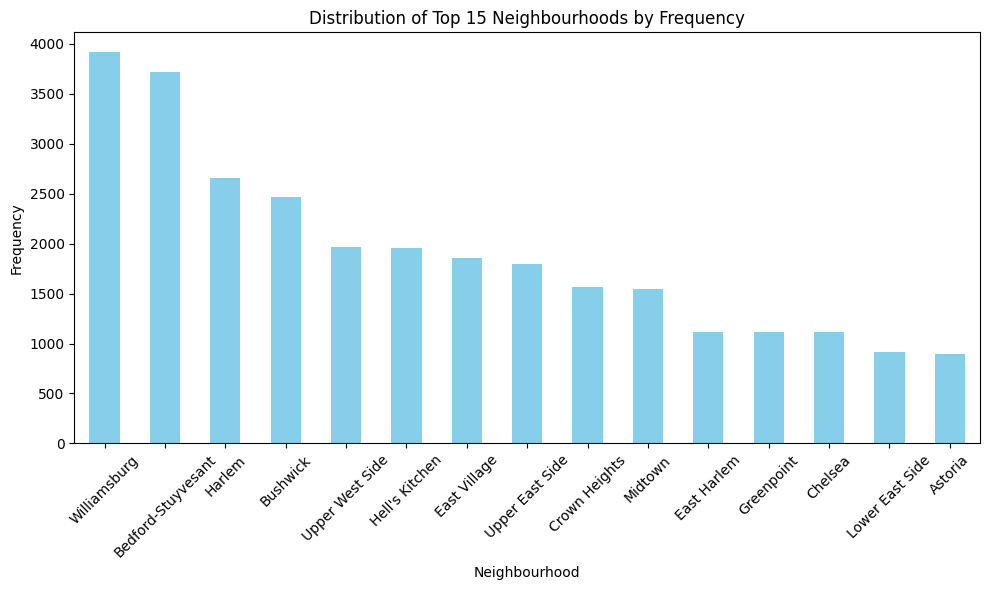

In [282]:
# Get the counts of each neighbourhood
neighbourhood_counts = air_df['neighbourhood'].value_counts()

# Select the top 15 most common neighbourhoods
top_neighbourhoods = neighbourhood_counts.head(15)

# Plot the distribution of neighbourhood
plt.figure(figsize=(10, 6))
top_neighbourhoods.plot(kind='bar', color='skyblue')
plt.title('Distribution of Top 15 Neighbourhoods by Frequency')
plt.xlabel('Neighbourhood')
plt.ylabel('Frequency')

# Rotate x axis labels by 45 degrees
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


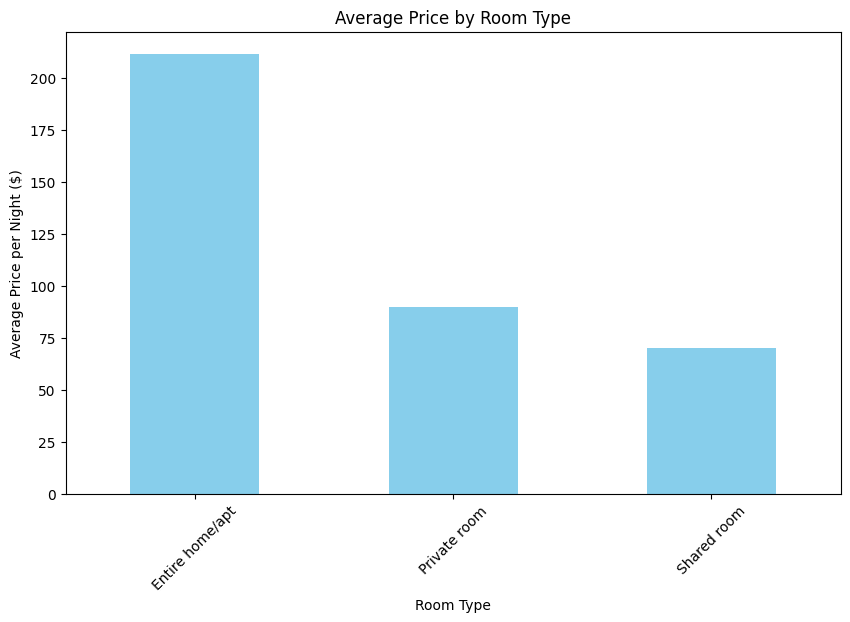

In [283]:

# Group data by 'room_type' and calculate mean
average_price_by_room_type = air_df.groupby('room_type')['price'].mean()

# Plot the average price by room_type
average_price_by_room_type.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Set the title and labels
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price per Night ($)')

# Rotate x axis labels by 45 degrees
plt.xticks(rotation=45)

# Show plot
plt.show()

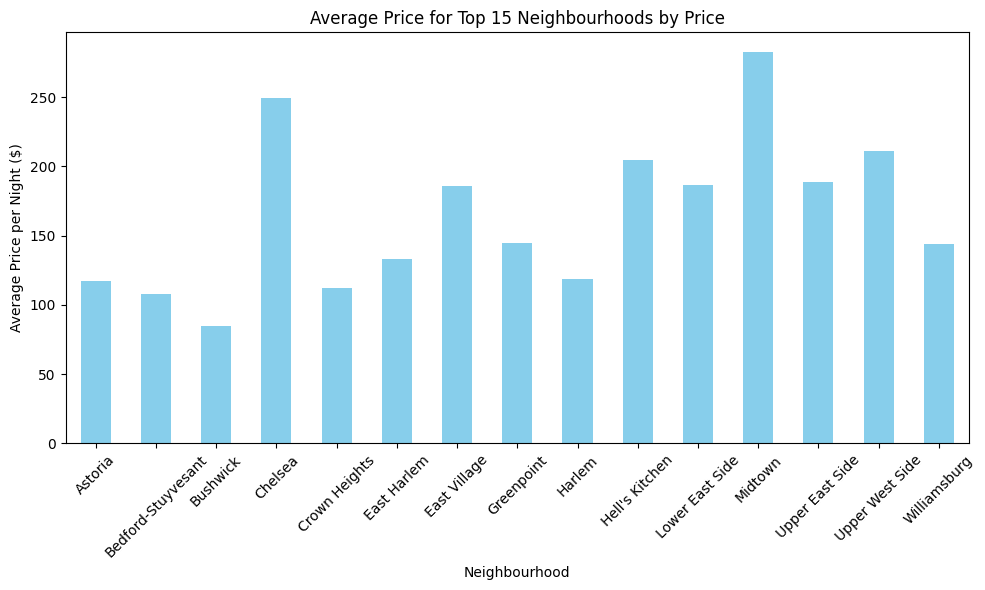

In [284]:
# Get the top 15 most common neighbourhoods
top_neighbourhoods = air_df['neighbourhood'].value_counts().head(15).index.tolist()

# Filter the DataFrame to include only data for the top 15 neighbourhoods
top_neighbourhood_data = air_df[air_df['neighbourhood'].isin(top_neighbourhoods)]

# Group the data by 'neighbourhood' and calculate the mean price within each group
average_price_by_neighbourhood = top_neighbourhood_data.groupby('neighbourhood')['price'].mean()

# Plot the average price for the top 15 neighbourhoods
plt.figure(figsize=(10, 6))
average_price_by_neighbourhood.plot(kind='bar', color='skyblue')
plt.title('Average Price for Top 15 Neighbourhoods by Price')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price per Night ($)')

# Rotate x axis labels by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


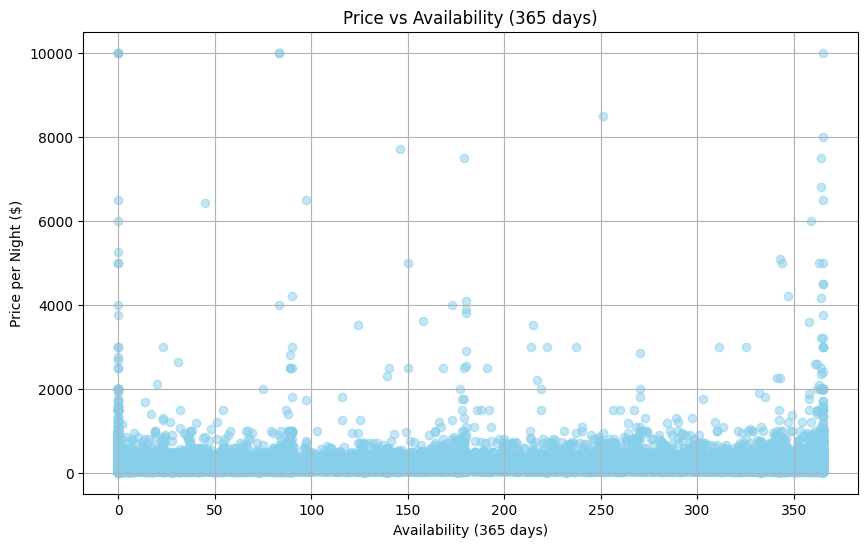

In [285]:
# Plot scatter plot of price vs availability_365
plt.figure(figsize=(10, 6))

plt.scatter(air_df['availability_365'], air_df['price'], alpha=0.5, color='skyblue')

plt.title('Price vs Availability (365 days)')
plt.xlabel('Availability (365 days)')
plt.ylabel('Price per Night ($)')
plt.grid(True)

plt.show()

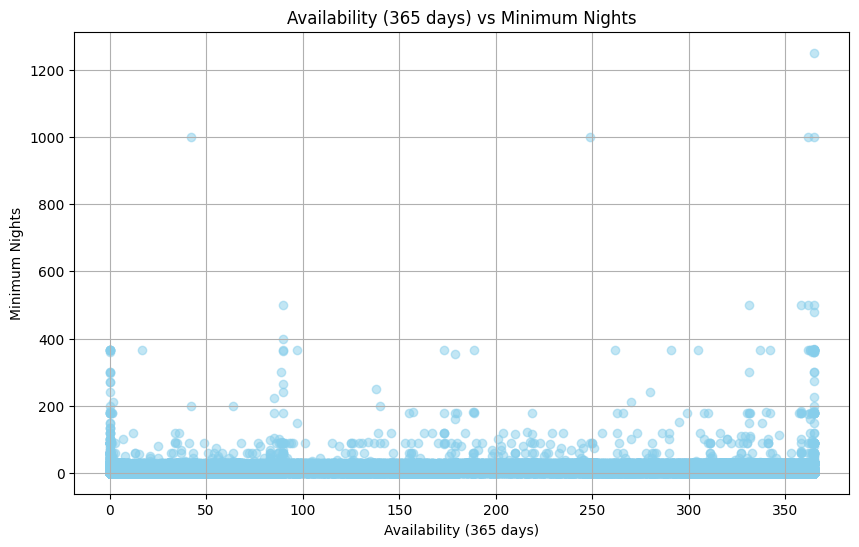

In [286]:
# Plot scatter plot of availability_365 vs minimum_nights
plt.figure(figsize=(10, 6))

plt.scatter(air_df['availability_365'], air_df['minimum_nights'], alpha=0.5, color='skyblue')

plt.title('Availability (365 days) vs Minimum Nights')
plt.xlabel('Availability (365 days)')
plt.ylabel('Minimum Nights')
plt.grid(True)

plt.show()

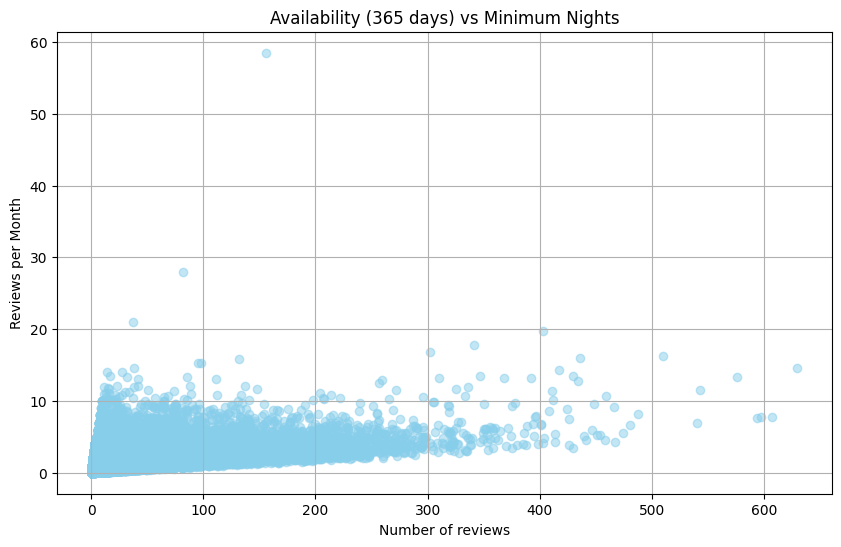

In [287]:
# Plot scatter plot of availability_365 vs minimum_nights
plt.figure(figsize=(10, 6))

plt.scatter(air_df['number_of_reviews'], air_df['reviews_per_month'], alpha=0.5, color='skyblue')

plt.title('Availability (365 days) vs Minimum Nights')
plt.xlabel('Number of reviews')
plt.ylabel('Reviews per Month')
plt.grid(True)

plt.show()

In [288]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [289]:
report(air_df)

,Column,d_type,unique_sample,n_uniques
0,id,int64,"[2539, 2595, 3647, 3831, 5022]",48895
1,name,object,"[Clean & quiet apt home by the park, Skylit Mi...",47905
2,host_id,int64,"[2787, 2845, 4632, 4869, 7192]",37457
3,host_name,object,"[John, Jennifer, Elisabeth, LisaRoxanne, Laura]",11452
4,neighbourhood_group,object,"[Brooklyn, Manhattan, Queens, Staten Island, B...",5
5,neighbourhood,object,"[Kensington, Midtown, Harlem, Clinton Hill, Ea...",221
6,latitude,float64,"[40.64749, 40.75362, 40.80902, 40.68514, 40.79...",19048
7,longitude,float64,"[-73.97237, -73.98377, -73.9419, -73.95976, -7...",14718
8,room_type,object,"[Private room, Entire home/apt, Shared room]",3
9,price,int64,"[149, 225, 150, 89, 80]",674


Lets change some object types to Categorical as it will make later analysis easier.

More specifically, we are going to change neighbourhood_group and room_type to categorical

In [290]:
air_df['neighbourhood_group'] = air_df['neighbourhood_group'].astype('category')
air_df['room_type'] = air_df['room_type'].astype('category')

In [291]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              48895 non-null  int64   
 1   name                            48879 non-null  object  
 2   host_id                         48895 non-null  int64   
 3   host_name                       48874 non-null  object  
 4   neighbourhood_group             48895 non-null  category
 5   neighbourhood                   48895 non-null  object  
 6   latitude                        48895 non-null  float64 
 7   longitude                       48895 non-null  float64 
 8   room_type                       48895 non-null  category
 9   price                           48895 non-null  int64   
 10  minimum_nights                  48895 non-null  int64   
 11  number_of_reviews               48895 non-null  int64   
 12  last_review       

We know that we have null values for 1052 entries, lets fill these null values with the mean of the column

In [292]:
air_df.fillna(air_df.mean(), inplace=True)
air_df.info()
air_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              48895 non-null  int64   
 1   name                            48879 non-null  object  
 2   host_id                         48895 non-null  int64   
 3   host_name                       48874 non-null  object  
 4   neighbourhood_group             48895 non-null  category
 5   neighbourhood                   48895 non-null  object  
 6   latitude                        48895 non-null  float64 
 7   longitude                       48895 non-null  float64 
 8   room_type                       48895 non-null  category
 9   price                           48895 non-null  int64   
 10  minimum_nights                  48895 non-null  int64   
 11  number_of_reviews               48895 non-null  int64   
 12  last_review       

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.373221,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0


Now, let's develope our first model, a Decision Tree Regression model

In [293]:
# Based on the correlations, set predictors and outcome
predictors = ['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'availability_365']
outcome = 'price'

# Create dummy variables for categorical predictors
X = pd.get_dummies(air_df[predictors], drop_first=True)
y = air_df[outcome]

# select the columns that are objects and typecast them to category
cat_cols = X.select_dtypes(include='object').columns
X[cat_cols] = X[cat_cols].astype('category')

Create our training and testing data:

In [294]:
# partition 80% of the data into training and 20% into testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0)

Lets fine-tune the hyperparameters of the model using GridSearchCV.

In [295]:
# Define the Decision Tree Regression model
dt_model = DecisionTreeRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,3,5,7,10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5)
grid_search.fit(train_X, train_y)

# Print the best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Make predictions with the best model
best_model = grid_search.best_estimator_
test_pred_y = best_model.predict(test_X)

# Calculate mean absolute error on the test set
mae = mean_absolute_error(test_y, test_pred_y)
print("Mean Squared Error on Test Set:", mae)

# Compare with LassoCV model
lasso_model = LassoCV(cv=5)
lasso_model.fit(train_X, train_y)
lasso_test_pred_y = lasso_model.predict(test_X)

lasso_mae = mean_absolute_error(test_y, lasso_test_pred_y)
print("Mean Squared Error with LassoCV:", lasso_mae)

Best parameters found by GridSearchCV:
{'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}
Mean Squared Error on Test Set: 69.73328037182786
Mean Squared Error with LassoCV: 74.92954822821314


Now, lets create the actual model with the best hyperparameters we found in the previous step.

In [296]:
# Initialize the DecisionTreeRegressor model with the best parameters
best_dt_model = DecisionTreeRegressor(criterion="squared_error", max_depth=5, min_samples_leaf=3, min_samples_split=2)

# Fit the model to the training data
best_dt_model.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)

Lets see the tree to verify the results.

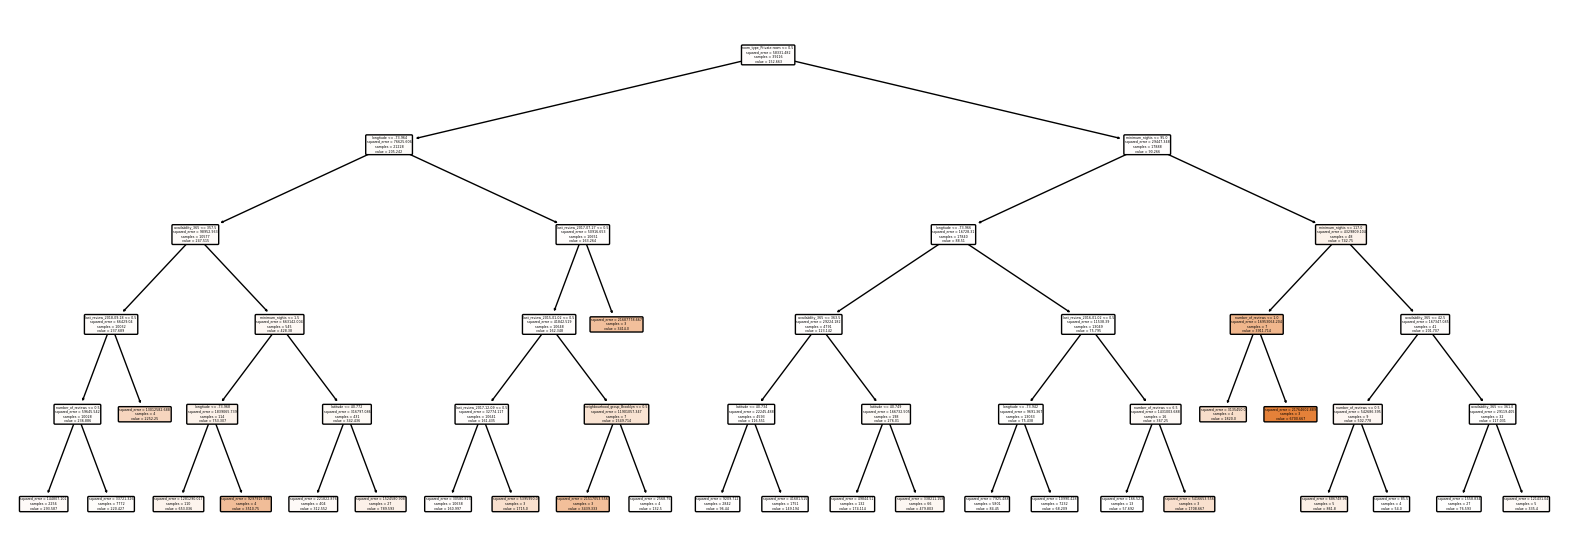

In [297]:
plt.figure(figsize=(20, 7))
plot_tree(best_dt_model, feature_names=train_X.columns.to_list(), filled = True, rounded = True)
plt.show()

Now, let's begin quickly testing the model. First, lets use MAE followed by cross validation with MAPE as the scoring.

In [298]:
# Make predictions on the validation data using the best DT Regressor model
val_pred_y = best_dt_model.predict(test_X)

# Calculate the MAE to quickly evaluate performance
mae = mean_absolute_error(test_y, val_pred_y)

print("Mean Absolute Percentage Error on Validation Data:", mae)

Mean Absolute Percentage Error on Validation Data: 74.35689405333234


In [299]:
# Perform cross-validation to evaluate the model's performance
cv_scores = cross_val_score(best_dt_model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Take the negative mean of the cv scores to get MAE
cv_mae = -cv_scores.mean()

print("Cross-Validation Mean Absolute Error:", cv_mae)

Cross-Validation Mean Absolute Error: 73.88596354290772


Lets implement a Gradient Boosting Regression model!
This builds smaller DT's off of the previous ones and should account for small errors within them, thus increasing performance.

In [300]:
# Create the Gradient Boosting Regression model
gb_model = GradientBoostingRegressor()

# Fit the model to the training data
gb_model.fit(train_X, train_y)

# Make predictions on the test data
y_pred = gb_model.predict(test_X)

# Quickly evaluate the model
mae = mean_absolute_error(test_y, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 69.45034711502922


Since we can't see all the trees that the model creates, lets try and visualize the performance using a scatter plot of the actual and predicted values using the Gradient Boosting Model.

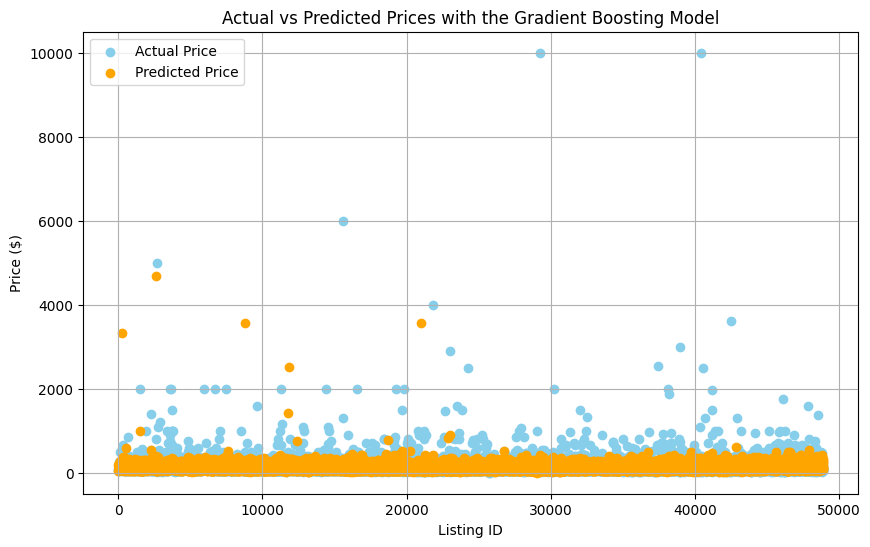

In [301]:
# Save the predicted values
predicted_values = gb_model.predict(test_X)

# Plotting the actual prices
plt.figure(figsize=(10, 6))
plt.scatter(test_X.index, test_y, color='skyblue', label='Actual Price')

# Plotting the predicted prices
plt.scatter(test_X.index, predicted_values, color='orange', label='Predicted Price')

plt.title('Actual vs Predicted Prices with the Gradient Boosting Model')
plt.xlabel('Listing ID')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()



Now, lets compare the accuracy to a dummy model, For the sake of simplicity and understanding, lets use the mean dummy model.

In [302]:
# Define the Dummy model using the mean value as the strategy (predict the mean value of the column)
dummy_model = DummyRegressor(strategy='mean')

# Train the Dummy model
dummy_model.fit(train_X, train_y)

# Make predictions with the Dummy model
dummy_test_pred_y = dummy_model.predict(test_X)

# Calculate mean absolute error for the Dummy model
dummy_mae = mean_absolute_error(test_y, dummy_test_pred_y)
print("Mean Absolute Error with Dummy model (mean strategy):", dummy_mae)

Mean Absolute Error with Dummy model (mean strategy): 93.34945129158264


Now, lets compare accuracy and error metrics for each model (Including LassoCV so we can compare it to the Decision Tree Regression model)

In [303]:
# Define a function to calculate multiple evaluation metrics
def calculate_metrics(true_y, pred_y):
    mae = mean_absolute_error(true_y, pred_y)
    mse = mean_squared_error(true_y, pred_y)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_y, pred_y)
    n = len(true_y)
    p = test_X.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Compute Adjusted R-squared
    return mae, mse, rmse, r2, adj_r2

# Evaluate Decision Tree model
dt_mae, dt_mse, dt_rmse, dt_r2, dt_adj_r2 = calculate_metrics(test_y, test_pred_y)

# Evaluate LassoCV model
lasso_mae, lasso_mse, lasso_rmse, lasso_r2, lasso_adj_r2 = calculate_metrics(test_y, lasso_test_pred_y)

# Evaluate Gradient Boosting model
gb_mae, gb_mse, gb_rmse, gb_r2, gb_adj_r2 = calculate_metrics(test_y, y_pred)

# Evaluate Dummy model
dummy_mae, dummy_mse, dummy_rmse, dummy_r2, dummy_adj_r2 = calculate_metrics(test_y, dummy_test_pred_y)

# Print the evaluation metrics for Decision Tree, Gradient Boosting, and Dummy models
print("Decision Tree Model:")
print("MAE:", dt_mae)
print("MSE:", dt_mse)
print("RMSE:", dt_rmse)
print("R-squared:", dt_r2)
print("Adjusted R-squared:", dt_adj_r2)
print()

print("LassoCV Model:")
print("MAE:", lasso_mae)
print("MSE:", lasso_mse)
print("RMSE:", lasso_rmse)
print("R-squared:", lasso_r2)
print("Adjusted R-squared:", lasso_adj_r2)
print()

print("Gradient Boosting Model:")
print("MAE:", gb_mae)
print("MSE:", gb_mse)
print("RMSE:", gb_rmse)
print("R-squared:", gb_r2)
print("Adjusted R-squared:", gb_adj_r2)
print()

print("Dummy Model:")
print("MAE:", dummy_mae)
print("MSE:", dummy_mse)
print("RMSE:", dummy_rmse)
print("R-squared:", dummy_r2)
print("Adjusted R-squared:", dummy_adj_r2)
print()



Decision Tree Model:
MAE: 69.73328037182786
MSE: 49996.24858786161
RMSE: 223.59840918007805
R-squared: 0.09160877191822858
Adjusted R-squared: -0.10972631536526234

LassoCV Model:
MAE: 74.92954822821314
MSE: 49722.400746358224
RMSE: 222.98520297624734
R-squared: 0.09658436476923304
Adjusted R-squared: -0.10364793619270851

Gradient Boosting Model:
MAE: 69.45034711502922
MSE: 53073.18201817909
RMSE: 230.376175022894
R-squared: 0.03570339068587447
Adjusted R-squared: -0.1780225194744527

Dummy Model:
MAE: 93.34945129158264
MSE: 55038.31691017777
RMSE: 234.60246569500876
R-squared: -1.5141481737313e-06
Adjusted R-squared: -0.2216410301525289



Gradient Boosting performed the best with the basic DT Regressor not far behind. LassoCV did a pretty good job for the ease of implementation. The Dummy Model performed drastically worse than any of the other models as expected. 